# Second and Higher Order models

In this notebook we will fit a higher-order state space model to the step test data. The learning goals for this notebook are to 

* Review the two-state model for the temperature control lab
* Reformulate systems of first order differential equations in state space
* Simulate the step response of state space models
* Fit a model to step test data using multiple fitting criteria.

## Example: Step Test Data

Using a Temperature Control Lab device initially at steady state at ambient room temperature, the following device settings were used to induce a step response in $T_1$ and $T_2$.  

| P1 | P2 | U1 | U2 |
| :--: | :--: | :--: | :--: |
| 200 | 100 | 50 | 0 |

Data was recorded for 800 seconds and saved to a .csv data file. Some noise and data dropouts are evident in the data. The data file is accessible at the link given in the code cell below. 

The challenge is to develop a first-principles models that reproduces the system measured response shown below.

In [7]:
import pandas as pd

data_file = "https://raw.githubusercontent.com/jckantor/cbe30338-book/main/notebooks/data/tclab-data-example.csv"
data = pd.read_csv(data_file)
data = data.set_index("Time")
data.head()

,T1,T2,Q1,Q2
Time,,,,
0.00,21.543,20.898,50.0,0.0
1.00,21.543,20.898,50.0,0.0
2.01,21.543,20.898,50.0,0.0
3.01,21.543,20.931,50.0,0.0
4.00,21.543,20.931,50.0,0.0


The Pandas library includes a highly functional method for plotting data.

<AxesSubplot: xlabel='Time', ylabel='% of power range'>

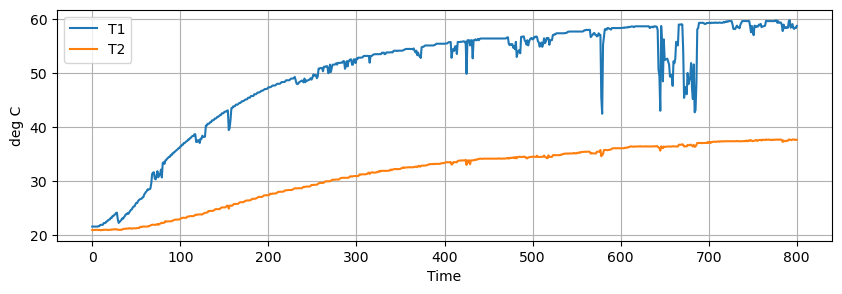

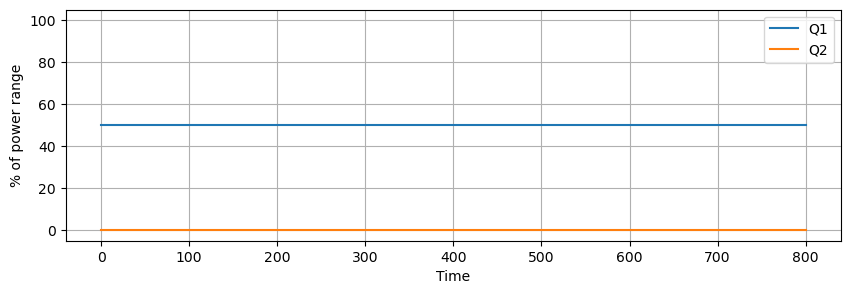

In [110]:
data.plot(y=["T1", "T2"], figsize=(10, 3), grid=True, ylabel="deg C")
data.plot(y=["Q1", "Q2"], figsize=(10, 3), grid=True, ylabel="% of power range", ylim=(-5, 105))

## Two-State Model

### Dynamics of the Heater/Sensor System

For this model we no longer assume  the heater and sensor are at the same temperature. To account for differing temperatures, we introduce $T_{H,1}$ to denote the temperature of heater one and $T_{S,1}$ to denote the temperature of the corresponding sensor. We further assume the sensor exchanges heat only with the heater, and heat transfer to the surroundings is dominated by the heat sink attached to the heater.

This motivates a model

$$
\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}
$$

where $C^H_p$ and $C^S_p$ are the heat capacities of the heater and sensor, respectively, and $U_b$ is a new heat transfer coefficient characterizing the exchange of heat between the heater and sensor. Where the temperature measured and recorded by the Arduino is given by

$$T_1 = T_{S,1}$$

The following cell creates a simulation of heater/sensor combination.

In [111]:
import numpy as np
from scipy.integrate import solve_ivp
import  pandas as pd

# known parameters
T_amb = 21             # deg C
alpha = 0.00016        # watts / (units P1 * percent U1)
P1 = 200               # P1 units

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C

# initial conditions
TH1 = T_amb
TS1 = T_amb
IC = [TH1, TS1]

# input values
U1 = 50                # steady state value of u1 (percent)

# extract data from experiment
t_expt = data.index

def tclab_ode(param):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub = param

    # model solution
    def deriv(t, y):
        TH1, TS1 = y
        dTH1 = (-Ua*(TH1 - T_amb) + Ub*(TS1 - TH1) + alpha*P1*U1)/CpH
        dTS1 = Ub*(TH1 - TS1)/CpS
        return [dTH1, dTS1]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [TH1_IC, TS1_IC], t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["Time"])
    pred["Time"] = t_expt
    pred = pred.set_index("Time")
    
    # report the model temperatures
    pred["TH1"] = soln.y[0]
    pred["TS1"] = soln.y[1]
    
    # report the prediced measurement
    pred["T1"] = pred["TS1"]
        
    return pred
    
pred = tclab_ode(param=[CpH, CpS, Ua, Ub])
pred.head()

,TH1,TS1,T1
Time,,,
0.00,21.000000,21.000000,21.000000
1.00,21.316847,21.007816,21.007816
2.01,21.630650,21.030852,21.030852
3.01,21.935475,21.067561,21.067561
4.00,22.231957,21.115691,21.115691


<AxesSubplot: xlabel='Time', ylabel='deg C'>

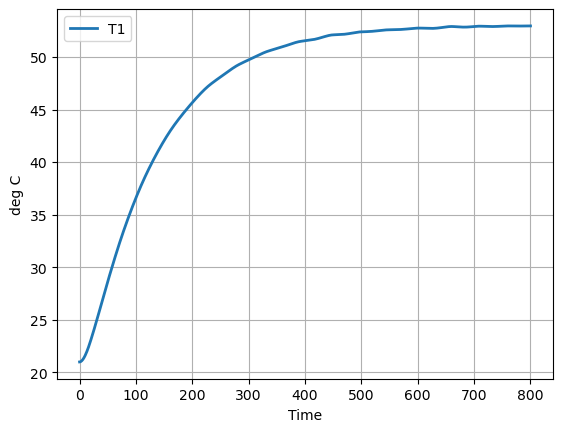

In [112]:
pred.plot(y=["T1"], grid=True, lw=2, ylabel="deg C")

Now let's compare the predicted measurement to the actual measurement. How did we do?

<AxesSubplot: xlabel='Time', ylabel='deg C'>

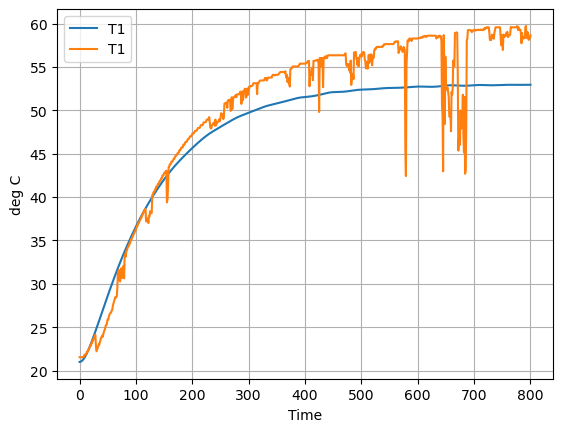

In [113]:
ax = pred.plot(y=["T1"], ylabel="deg C")
data.plot(ax=ax, y=["T1"], grid=True)

## State Space Model

Our two-state model for the temperature control lab is given by 

$$
\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}
$$

The initial steady state is $T_{amb}$. So let's write the dependent variables as excursions from the ambient temperature.

$$
\begin{align}
C^H_p\frac{d(T_{H,1} - T_{amb})}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b((T_{S,1} - T_{amb}) - (T_{H,1} - T_{amb})) + \alpha P_1u_1\\
C^S_p\frac{d(T_{S,1} - T_{amb})}{dt} & = U_b(T_{H,1} - T_{amb}) - (T_{S,1} - T_{amb})
\end{align}
$$

Then divide by the heat capacities.

$$
\begin{align}
\frac{d(T_{H,1} - T_{amb})}{dt} & = -\frac{U_a+U_b}{C^H_p}(T_{H,1} - T_{amb}) + \frac{U_b}{C^H_p}(T_{S,1} - T_{amb}) + \frac{\alpha P_1}{C^H_p}u_1 \\
\frac{d(T_{S,1} - T_{amb})}{dt} & = \frac{U_b}{C^S_p}((T_{H,1} - T_{amb}) - \frac{U_b}{C^S_p} (T_{S,1} - T_{amb})) 
\end{align}
$$

The two-state model can be rewritten using vectors to collect the states, inputs, measurable outputs, and arrays to collect the coefficients of the differential equations. 

$$
\begin{align}
\frac{d}{dt}\underbrace{\begin{bmatrix} T_{H,1} - T_{amb} \\ T_{S,1} - T_{amb} \end{bmatrix}}_x & = 
\underbrace{\begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & - \frac{U_b}{C^S_p}\end{bmatrix}}_A 
\underbrace{\begin{bmatrix} T_{H,1} - T_{amb} \\ T_{S,1} - T_{amb} \end{bmatrix}}_x + 
\underbrace{\begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix}}_B 
\underbrace{\begin{bmatrix} u_1 \end{bmatrix}}_u \\
\\
\underbrace{\begin{bmatrix} T_{S,1} - T_{amb} \end{bmatrix}}_y & = 
\underbrace{\begin{bmatrix}0 & 1 \end{bmatrix}}_C 
\underbrace{\begin{bmatrix} T_{H,1} - T_{amb} \\ T_{S,1} - T_{amb} \end{bmatrix}}_x
\end{align}
$$

In other words, we can write the temperature control lab model as a **state-space model**

$$
\begin{align}
\frac{dx}{dt} & = A x + B u \\
y & = C x
\end{align}
$$

where the process variables are 

$$
\begin{align}
u & = \begin{bmatrix} u_1 \end{bmatrix} && \text{inputs} \\
\\
x & = \begin{bmatrix} T_{H,1} - T_{amb} \\ T_{S,1} - T_{amb} \end{bmatrix} && \text{states} \\
\\
y & = \begin{bmatrix} T_{S,1} \end{bmatrix} && \text{measurements} \\
\end{align}
$$

and parameters are embedded in the arrays

$$
\begin{align}
A = \begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U|_b}{C^H_p} \\ \frac{U_b}{C^S_p} & - \frac{U_b}{C^S_p}\end{bmatrix}
\quad
B = \begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix} 
\quad
C = \begin{bmatrix}0 & 1 \end{bmatrix} \\
\end{align}
$$

By using the notation and techniques of linear algebra, **state-space models** provide a compact means of representing complex systems. This example consists of $m=1$ inputs, $n=2$ states, and $p=1$ outputs.

In [92]:
import numpy as np
from scipy.integrate import solve_ivp
import  pandas as pd

# known parameters
T_amb = 21             # deg C
alpha = 0.00016        # watts / (units P1 * percent U1)
P1 = 200               # P1 units

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C

# array parameters
A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
B = np.array([[alpha*P1/CpH], [0]])
C = np.array([[0, 1]])

print(f"\n{A=}")
print(f"\n{B=}")
print(f"\n{C=}")


A=array([[-0.02,  0.01],
       [ 0.05, -0.05]])

B=array([[0.0064],
       [0.    ]])

C=array([[0, 1]])


In [129]:

# input values
U1 = 50                # steady state value of u1 (percent)
def u(t):
    return np.array([U1])

# extract data from experiment
t_expt = data.index

def tclab_ss(A, B, C):
    
    IC = [0, 0]

    # model solution
    def deriv(t, x):
        dxdt = A @ x + B @ u(t)
        return dxdt

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], IC, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["Time"])
    pred["Time"] = t_expt
    pred = pred.set_index("Time")
    
    # get the state variables
    pred["x1"] = soln.y[0]
    pred["x2"] = soln.y[1]
    
    # convert back to model temperatures
    pred["TH1"] = pred["x1"] + T_amb
    pred["TS1"] = pred["x2"] + T_amb
    
    # report the predicated measurement
    pred["T1"] = pred["TS1"]
      
    return pred
    
pred = tclab_ss(A, B, C)

pred.head()

,x1,x2,TH1,TS1,T1
Time,,,,,
0.00,0.000000,0.000000,21.000000,21.000000,21.000000
1.00,0.316847,0.007816,21.316847,21.007816,21.007816
2.01,0.630651,0.030850,21.630651,21.030850,21.030850
3.01,0.935462,0.067618,21.935462,21.067618,21.067618
4.00,1.231700,0.116765,22.231700,21.116765,21.116765


<AxesSubplot: xlabel='Time'>

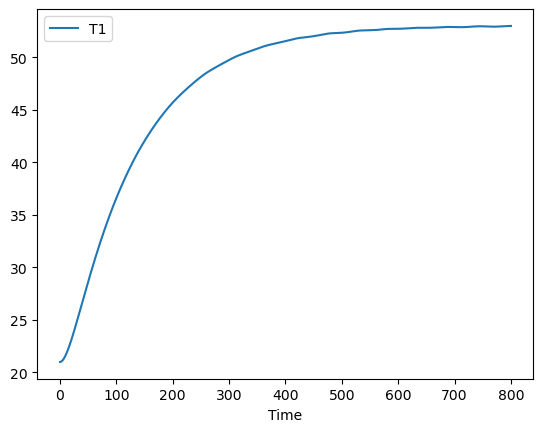

In [130]:
pred.plot(y=["T1"])

### "Least Squares" Model Fitting

Fitting a model to data is a basic task in engineering, science, business, and a foundation of modern data sciences. For engineers the goal is to validate hypotheses about how a device works, then to enable simulation and design. In the data science model fitting may be almost completely empirical using black box models to develop predictive models of complex systems.

In this case we wish to find values for a small number of parameters that cause a model to replicate a measured response. One common measure of fit is the sum of sum of squares of residual difference between the model and data. For residuals modeled as independent and identically distributed random variables from a Gaussian distribution, minimizing the sum of squares has a strong theoretical foundation. So strong, in fact, the term "least squares" has become synonomous with model fitting and regression.

The SciPy library includes a well-developed function [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) for this purpose. The name is a misnomoer because the function allows other common "loss" functions in addition to sum of squares. The simplest use of `least_squares` is to provide a function that, given values for the unknown parameters, creates a vector of residuals between a model and data. 

This is demonstrated below.

<AxesSubplot: xlabel='Time'>

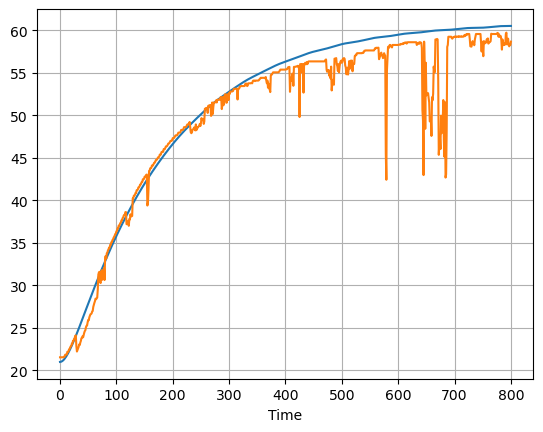

In [137]:
# Try your hand at trial and error data fitting

# adjustable parameters
CpH = 6                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.04             # watts/deg C
Ub = 0.05              # watts/deg C

A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
B = np.array([[alpha*P1/CpH], [0]])
C = np.array([[0, 1]])

pred = tclab_ss(A, B, C)
ax = pred["T1"].plot()
data["T1"].plot(ax=ax, grid=True)


<AxesSubplot: xlabel='Time'>

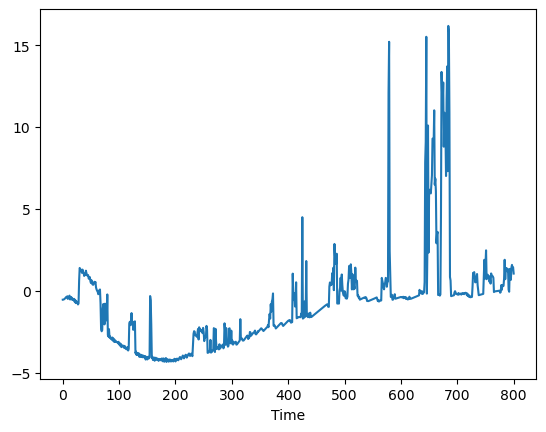

In [139]:
def pred_err(p):
    
    CpH, CpS, Ua, Ub = p
    
    # array parameters
    A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
    B = np.array([[alpha*P1/CpH], [0]])
    C = np.array([[0, 1]])
    
    pred = tclab_ss(A, B, C)
    return pred["T1"] - data["T1"]

    
pred_err([8, 1, 0.04, 0.05]).plot()

CpH = 5.228060928587527,  CpS = 1.9896637181582368,   Ua = 0.041571036467889934,  Ub = 0.21309424723032316


<AxesSubplot: xlabel='Time'>

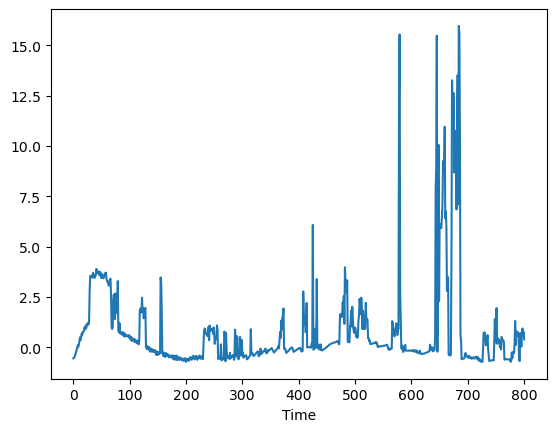

In [147]:
from scipy.optimize import least_squares

results = least_squares(pred_err,  [8, 1, 0.05, 0.05], loss='cauchy')

CpH, CpS, Ua, Ub = results.x
print(f"CpH = {CpH},  CpS = {CpS},   Ua = {Ua},  Ub = {Ub}")

pred_err([CpH, CpS, Ua, Ub]).plot()

<AxesSubplot: xlabel='Time'>

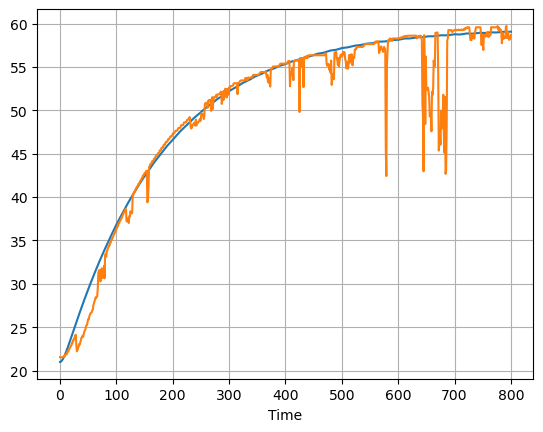

In [148]:
A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
B = np.array([[alpha*P1/CpH], [0]])
C = np.array([[0, 1]])

pred = tclab_ss(A, B, C)
ax = pred["T1"].plot()
data["T1"].plot(ax=ax, grid=True)

:::{admonition} Choosing a Loss Function

Consult the documentation page [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). Modify the regression to use alternative loss functions including `soft_l1`, `huber`, `cauchy` and `arctan`. 

1. Which gives the best result? 
2. From the documentation, why is the fit better? 
3. How much of difference does it make it estimated model parameters?

:::

## Fourth-Order Multi-Input Multi-Output Model

The next step in the evolution of our model is to incorporate the second heater/sensor assembly. Even with only heat applied to 

### Model derivation

$$
\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + U_c(T_{H,2}-T_{H,1})  + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1})  \\
C^H_p\frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{S,2} - T_{H,2}) + U_c(T_{H,1}-T_{H,2}) + \alpha P_2 u_2\\
C^S_p\frac{dT_{S,2}}{dt} & = U_b(T_{H,2} - T_{S,2}) 
\end{align}
$$

where

$$
\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}
$$

### Standard form

Normalize the derivatives to get in proper form for `solve_ivp`.

$$
\begin{align}
\frac{dT_{H,1}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{U_c}{C^H_p}T_{H,2}  + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1})  \\
\frac{dT_{H,2}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})T_{H,2} + \frac{U_b}{C^H_p}T_{S,2} + \frac{U_c}{C^H_p}T_{H,1}  + \frac{\alpha P_2}{C^H_p}u_2 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,2}}{dt} & = \frac{U_b}{C^S_p}(T_{H,2} - T_{S,2}) 
\end{align}
$$

where

$$
\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}
$$


<AxesSubplot:xlabel='Time'>

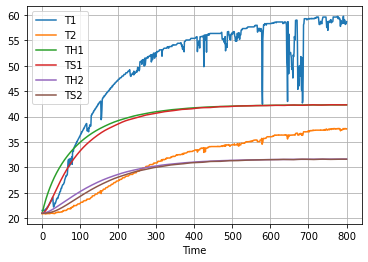

In [23]:
import numpy as np
from scipy.integrate import solve_ivp

# known parameters
T_amb = 21             # deg C
alpha = 0.00016        # watts / (units P1 * percent U1)
P1 = 200               # P1 units
U1 = 50                # steady state value of u1 (percent)
P2 = 100               # P2 units
U2 = 0                 # steady state value of u1 (percent)

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C
Uc = 0.05              # watts/deg C

def tclab_model4(param):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub, Uc = param  

    # model solution
    def deriv(t, y):
        T1H, T1S, T2H, T2S= y
        dT1H = (-(Ua + Ub + Uc)*T1H + Ub*T1S + Uc*T2H + alpha*P1*U1 + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        dT2H = (-(Ua + Ub + Uc)*T2H + Ub*T2S + Uc*T1H + alpha*P2*U2 + Ua*T_amb)/CpH
        dT2S = Ub*(T2H - T2S)/CpS
        return [dT1H, dT1S, dT2H, dT2S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb]*4, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(t_expt, columns=["Time"])
    pred["TH1"] = soln.y[0]
    pred["TS1"] = soln.y[1]
    pred["TH2"] = soln.y[2]
    pred["TS2"] = soln.y[3]
    
    return pred
    
pred = tclab_model4([CpH, CpS, Ua, Ub, Uc])

ax = data.plot(x="Time", y=["T1", "T2"])
pred.plot(x="Time", y = ["TH1", "TS1", "TH2", "TS2"], ax=ax, grid=True)

Least squares fitting with Cauchy loss function.

CpH = 5.84,  CpS = 0.02372,   Ua = 0.02885,  Ub = 0.0010209, Uc = 0.0217


<AxesSubplot:xlabel='Time'>

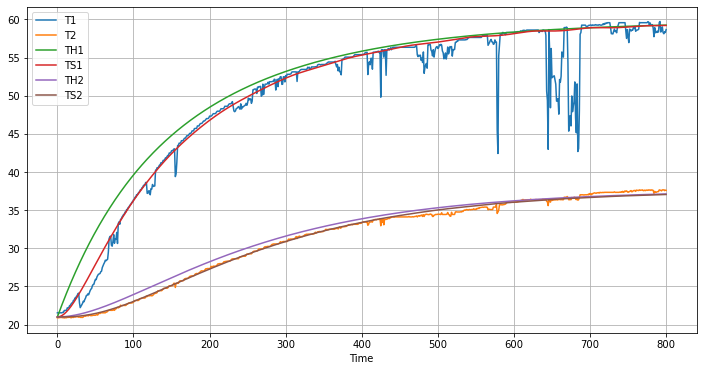

In [24]:
from scipy.optimize import least_squares

# define function to be minimized by least_squares
def fun(p):
    pred = tclab_model4(p)
    return pd.concat([pred["TS1"] - data["T1"], pred["TS2"] - data["T2"]])

# compute the least_squares best fit for parameters
results = least_squares(fun,  [CpH, CpS, Ua, Ub, Uc], loss="cauchy")
CpH, CpS, Ua, Ub, Uc = results.x
print(f"CpH = {CpH:0.2f},  CpS = {CpS:.5f},   Ua = {Ua:.5f},  Ub = {Ub:.7f}, Uc = {Uc:.4f}")

# show the new prediction with optimized parameters
pred = tclab_model4(results.x)
ax = data.plot(x="Time", y=["T1", "T2"], figsize=(12, 6))
pred.plot(x="Time", y = ["TH1", "TS1", "TH2", "TS2"], ax=ax, grid=True)